In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [13]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="s4FZabiIIE2JRuSa8MFn")
project = rf.workspace("krishi-oz05i").project("agrifarm-3zwm0")
version = project.version(13)
dataset = version.download("png-mask-semantic")
                

loading Roboflow workspace...
loading Roboflow project...


In [14]:
import os
import shutil

# Original folder containing mixed files
src_dir = "/kaggle/working/AGRIFARM-13/train"

# Destination folders
img_dest = "/kaggle/working/train/images"
mask_dest = "/kaggle/working/train/masks"

# Create destination folders if they don't exist
os.makedirs(img_dest, exist_ok=True)
os.makedirs(mask_dest, exist_ok=True)

# Move files
for f in os.listdir(src_dir):
    src_path = os.path.join(src_dir, f)
    if f.endswith(".jpg"):
        shutil.copy(src_path, os.path.join(img_dest, f))
    elif f.endswith("_mask.png"):
        shutil.copy(src_path, os.path.join(mask_dest, f))

print(f"✅ All images moved to {img_dest}")
print(f"✅ All masks moved to {mask_dest}")


✅ All images moved to /kaggle/working/train/images
✅ All masks moved to /kaggle/working/train/masks


In [15]:
import os
import shutil

# Original folder containing mixed files
src_dir = "/kaggle/working/AGRIFARM-13/valid"

# Destination folders
img_dest = "/kaggle/working/valid/images"
mask_dest = "/kaggle/working/valid/masks"

# Create destination folders if they don't exist
os.makedirs(img_dest, exist_ok=True)
os.makedirs(mask_dest, exist_ok=True)

# Move files
for f in os.listdir(src_dir):
    src_path = os.path.join(src_dir, f)
    if f.endswith(".jpg"):
        shutil.copy(src_path, os.path.join(img_dest, f))
    elif f.endswith("_mask.png"):
        shutil.copy(src_path, os.path.join(mask_dest, f))

print(f"✅ All images moved to {img_dest}")
print(f"✅ All masks moved to {mask_dest}")


✅ All images moved to /kaggle/working/valid/images
✅ All masks moved to /kaggle/working/valid/masks


In [16]:
import os
import shutil

# Original folder containing mixed files
src_dir = "/kaggle/working/AGRIFARM-13/test"

# Destination folders
img_dest = "/kaggle/working/test/images"
mask_dest = "/kaggle/working/test/masks"

# Create destination folders if they don't exist
os.makedirs(img_dest, exist_ok=True)
os.makedirs(mask_dest, exist_ok=True)

# Move files
for f in os.listdir(src_dir):
    src_path = os.path.join(src_dir, f)
    if f.endswith(".jpg"):
        shutil.copy(src_path, os.path.join(img_dest, f))
    elif f.endswith("_mask.png"):
        shutil.copy(src_path, os.path.join(mask_dest, f))

print(f"✅ All images moved to {img_dest}")
print(f"✅ All masks moved to {mask_dest}")


✅ All images moved to /kaggle/working/test/images
✅ All masks moved to /kaggle/working/test/masks


In [17]:
with open("/kaggle/working/AGRIFARM-13/train/_classes.csv", "r") as f:
    for line in f:
        print(line.strip())  # remove trailing newline


Pixel Value, Class
0, background
1, Barrenland
2, Bush
3, Farmland
4, Sand
5, Tree
6, edgecase


In [18]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ==========================================
# 1. CONFIGURATION
# ==========================================
CONFIG = {
    "ROOT_DIR": "/kaggle/working",       
    "IMG_SIZE": 512,
    "BATCH_SIZE": 8,              
    "LR": 1e-4,
    "EPOCHS": 60,                 
    "PATIENCE": 12,               
    # 4 Classes: 0:Back, 1:Veg(Barren+Bush+Tree), 2:Farm, 3:Sand
    "NUM_CLASSES_TO_TRAIN": 4,    
    "IGNORE_INDEX": 255,          
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "MODEL_SAVE_PATH": "vgg16_unet_best_4classes.pth"
}

# ==========================================
# 2. LOSS FUNCTIONS (FIXED)
# ==========================================
class DiceLoss(nn.Module):
    def __init__(self, ignore_index=255, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.ignore_index = ignore_index
        self.smooth = smooth

    def forward(self, inputs, targets):
        # inputs: (B, C, H, W) logits
        # targets: (B, H, W) labels
        num_classes = inputs.shape[1]
        
        # Apply Softmax to get probabilities
        inputs = F.softmax(inputs, dim=1)
        
        # --- 🚨 FIX STARTS HERE 🚨 ---
        # 1. Create a safe target tensor for one_hot encoding
        # We clone it so we don't mess up the original targets for CrossEntropy
        targets_safe = targets.clone()
        
        # Identify ignored pixels
        mask_ignore = (targets == self.ignore_index)
        
        # Replace 255 with 0 temporarily so one_hot doesn't crash
        targets_safe[mask_ignore] = 0 
        
        # 2. Create One-Hot
        targets_one_hot = F.one_hot(targets_safe, num_classes=num_classes).permute(0, 3, 1, 2).float()
        
        # 3. Zero out the ignored regions in the One-Hot tensor
        # We create a mask where valid=1, ignore=0
        valid_mask = (~mask_ignore).unsqueeze(1).float() # (B, 1, H, W)
        
        # Apply mask to inputs and targets
        inputs = inputs * valid_mask
        targets_one_hot = targets_one_hot * valid_mask
        # --- 🚨 FIX ENDS HERE 🚨 ---

        # Flatten and calculate Dice
        inputs_flat = inputs.contiguous().view(-1)
        targets_flat = targets_one_hot.contiguous().view(-1)
        
        intersection = (inputs_flat * targets_flat).sum()
        dice = (2. * intersection + self.smooth) / (inputs_flat.sum() + targets_flat.sum() + self.smooth)
        
        return 1 - dice

class ComboLoss(nn.Module):
    def __init__(self, weight=None, ignore_index=255):
        super(ComboLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index, label_smoothing=0.1)
        self.dice = DiceLoss(ignore_index=ignore_index)

    def forward(self, inputs, targets):
        loss_ce = self.ce(inputs, targets)
        loss_dice = self.dice(inputs, targets)
        return 0.5 * loss_ce + 0.5 * loss_dice

# ==========================================
# 3. DATASET
# ==========================================
class FarmDataset(Dataset):
    def __init__(self, root_dir, split="train"):
        self.img_dir = os.path.join(root_dir, split, "images")
        self.mask_dir = os.path.join(root_dir, split, "masks")
        self.images = sorted([f for f in os.listdir(self.img_dir) if f.endswith('.jpg')])
        
        if split == "train":
            self.transform = A.Compose([
                A.Resize(height=CONFIG['IMG_SIZE'], width=CONFIG['IMG_SIZE']),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.RandomBrightnessContrast(p=0.3),
                A.HueSaturationValue(p=0.3),
                A.GaussianBlur(p=0.1),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ])
        else:
            self.transform = A.Compose([
                A.Resize(height=CONFIG['IMG_SIZE'], width=CONFIG['IMG_SIZE']),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = img_name.replace(".jpg", "_mask.png")
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))

        # Mapping Logic (4 Classes)
        new_mask = np.zeros_like(mask) # 0: Background

        # 1: Vegetation (Barren + Bush + Tree)
        new_mask[(mask == 1) | (mask == 2) | (mask == 5)] = 1
        
        # 2: Farmland
        new_mask[mask == 3] = 2
        
        # 3: Sand
        new_mask[mask == 4] = 3
        
        # Ignore Edgecase (6) and artifacts
        new_mask[mask == 6] = CONFIG["IGNORE_INDEX"]
        new_mask[mask > 6] = CONFIG["IGNORE_INDEX"]

        augmentations = self.transform(image=image, mask=new_mask)
        return augmentations["image"], augmentations["mask"].long()

# ==========================================
# 4. METRICS & EARLY STOPPING
# ==========================================
def compute_dice_score(preds, targets, num_classes, ignore_index=255):
    pred_mask = torch.argmax(preds, dim=1)
    dice_list = []
    for c in range(num_classes):
        p_c = (pred_mask == c)
        t_c = (targets == c)
        valid_pixels = (targets != ignore_index)
        p_c = p_c & valid_pixels
        t_c = t_c & valid_pixels
        intersection = (p_c & t_c).sum().float()
        union = p_c.sum().float() + t_c.sum().float()
        if union == 0:
            score = 1.0 if t_c.sum() == 0 else 0.0
        else:
            score = ((2.0 * intersection) / (union + 1e-6)).item()
        dice_list.append(score)
    return np.mean(dice_list)

class EarlyStoppingDice:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = -np.Inf
        self.early_stop = False
        self.delta = delta
        self.path = path

    def __call__(self, current_score, model):
        if current_score > self.best_score + self.delta:
            self.best_score = current_score
            if self.verbose:
                print(f'Dice Improved to {current_score:.4f}. Saving model...')
            torch.save(model.state_dict(), self.path)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# ==========================================
# 5. MODEL
# ==========================================
class VGG16UNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(VGG16UNet, self).__init__()
        vgg16 = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT if pretrained else None)
        features = list(vgg16.features.children())
        self.enc1 = nn.Sequential(*features[:6])    
        self.enc2 = nn.Sequential(*features[6:13])  
        self.enc3 = nn.Sequential(*features[13:23]) 
        self.enc4 = nn.Sequential(*features[23:33]) 
        self.enc5 = nn.Sequential(*features[33:43]) 
        self.pool = nn.MaxPool2d(2, 2)
        self.up1 = self.conv_block(512 + 512, 512)
        self.up2 = self.conv_block(512 + 256, 256)
        self.up3 = self.conv_block(256 + 128, 128)
        self.up4 = self.conv_block(128 + 64, 64)
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool(e1)
        e2 = self.enc2(p1)
        p2 = self.pool(e2)
        e3 = self.enc3(p2)
        p3 = self.pool(e3)
        e4 = self.enc4(p3)
        p4 = self.pool(e4)
        e5 = self.enc5(p4)
        d1 = F.interpolate(e5, scale_factor=2, mode='bilinear', align_corners=True)
        if d1.size()[2:] != e4.size()[2:]: d1 = F.interpolate(d1, size=e4.shape[2:], mode='bilinear')
        d1 = torch.cat([d1, e4], dim=1)
        d1 = self.up1(d1)
        d2 = F.interpolate(d1, scale_factor=2, mode='bilinear', align_corners=True)
        if d2.size()[2:] != e3.size()[2:]: d2 = F.interpolate(d2, size=e3.shape[2:], mode='bilinear')
        d2 = torch.cat([d2, e3], dim=1)
        d2 = self.up2(d2)
        d3 = F.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=True)
        if d3.size()[2:] != e2.size()[2:]: d3 = F.interpolate(d3, size=e2.shape[2:], mode='bilinear')
        d3 = torch.cat([d3, e2], dim=1)
        d3 = self.up3(d3)
        d4 = F.interpolate(d3, scale_factor=2, mode='bilinear', align_corners=True)
        if d4.size()[2:] != e1.size()[2:]: d4 = F.interpolate(d4, size=e1.shape[2:], mode='bilinear')
        d4 = torch.cat([d4, e1], dim=1)
        d4 = self.up4(d4)
        return self.final_conv(d4)

# ==========================================
# 6. TRAINING EXECUTION
# ==========================================
def train():
    print(f"--- Training Improved VGG16 U-Net (4 Classes) ---")
    
    model = VGG16UNet(num_classes=CONFIG['NUM_CLASSES_TO_TRAIN']).to(CONFIG['DEVICE'])
    
    train_ds = FarmDataset(CONFIG['ROOT_DIR'], split="train")
    if os.path.exists(os.path.join(CONFIG['ROOT_DIR'], "valid")):
        val_ds = FarmDataset(CONFIG['ROOT_DIR'], split="valid")
    else:
        train_size = int(0.8 * len(train_ds))
        val_size = len(train_ds) - train_size
        train_ds, val_ds = torch.utils.data.random_split(train_ds, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2, pin_memory=True)

    # Class Weights: [Back, Veg, Farm, Sand]
    class_weights = torch.tensor([0.5, 1.5, 1.0, 1.0]).to(CONFIG['DEVICE'])
    
    criterion = ComboLoss(weight=class_weights, ignore_index=CONFIG['IGNORE_INDEX'])
    optimizer = Adam(model.parameters(), lr=CONFIG['LR'])
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
    early_stopping = EarlyStoppingDice(patience=CONFIG['PATIENCE'], verbose=True, path=CONFIG['MODEL_SAVE_PATH'])

    for epoch in range(CONFIG['EPOCHS']):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['EPOCHS']}")
        
        for images, masks in loop:
            images = images.to(CONFIG['DEVICE'])
            masks = masks.to(CONFIG['DEVICE'])

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())

        # Validation
        model.eval()
        val_dice_scores = []
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(CONFIG['DEVICE'])
                masks = masks.to(CONFIG['DEVICE'])
                outputs = model(images)
                
                if outputs.shape[-2:] != masks.shape[-2:]:
                     outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)

                batch_dice = compute_dice_score(
                    preds=outputs, targets=masks, 
                    num_classes=CONFIG['NUM_CLASSES_TO_TRAIN'],
                    ignore_index=CONFIG['IGNORE_INDEX']
                )
                val_dice_scores.append(batch_dice)

        avg_val_dice = np.mean(val_dice_scores)
        print(f"Val Dice: {avg_val_dice:.4f}")

        scheduler.step(avg_val_dice)
        early_stopping(avg_val_dice, model)
        
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

if __name__ == "__main__":
    train()

--- Training Improved VGG16 U-Net (4 Classes) ---


Epoch 1/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=1.64] 


Val Dice: 0.4863
Dice Improved to 0.4863. Saving model...


Epoch 2/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=1.09] 


Val Dice: 0.5453
Dice Improved to 0.5453. Saving model...


Epoch 3/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=1.13] 


Val Dice: 0.5067


Epoch 4/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=1.02] 


Val Dice: 0.5500
Dice Improved to 0.5500. Saving model...


Epoch 5/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=1.19] 


Val Dice: 0.5625
Dice Improved to 0.5625. Saving model...


Epoch 6/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=1.18] 


Val Dice: 0.5702
Dice Improved to 0.5702. Saving model...


Epoch 7/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=1.22] 


Val Dice: 0.6213
Dice Improved to 0.6213. Saving model...


Epoch 8/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=0.892]


Val Dice: 0.5826


Epoch 9/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=nan]  


Val Dice: 0.5904


Epoch 10/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=1.94] 


Val Dice: 0.6222
Dice Improved to 0.6222. Saving model...


Epoch 11/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=0.917]


Val Dice: 0.6003


Epoch 12/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=0.711]


Val Dice: 0.6298
Dice Improved to 0.6298. Saving model...


Epoch 13/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=1.24] 


Val Dice: 0.6923
Dice Improved to 0.6923. Saving model...


Epoch 14/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=1.29] 


Val Dice: 0.6658


Epoch 15/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=0.898]


Val Dice: 0.6473


Epoch 16/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=0.905]


Val Dice: 0.6399


Epoch 17/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=0.955]


Val Dice: 0.6487


Epoch 18/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=1.22] 


Val Dice: 0.6906


Epoch 19/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=0.741]


Val Dice: 0.6556


Epoch 20/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=1.28] 


Val Dice: 0.6863


Epoch 21/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=0.733]


Val Dice: 0.6673


Epoch 22/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=0.81] 


Val Dice: 0.6761


Epoch 23/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=0.872]


Val Dice: 0.6736


Epoch 24/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=0.797]


Val Dice: 0.6869


Epoch 25/60: 100%|██████████| 87/87 [00:41<00:00,  2.12it/s, loss=0.81] 


Val Dice: 0.6837
Early stopping triggered.


In [1]:
import gc
import torch

gc.collect()  # Collect and clean up memory
torch.cuda.empty_cache()  # Free up GPU memory


Loading Model...
Model loaded.
Visualizing 5 random images...


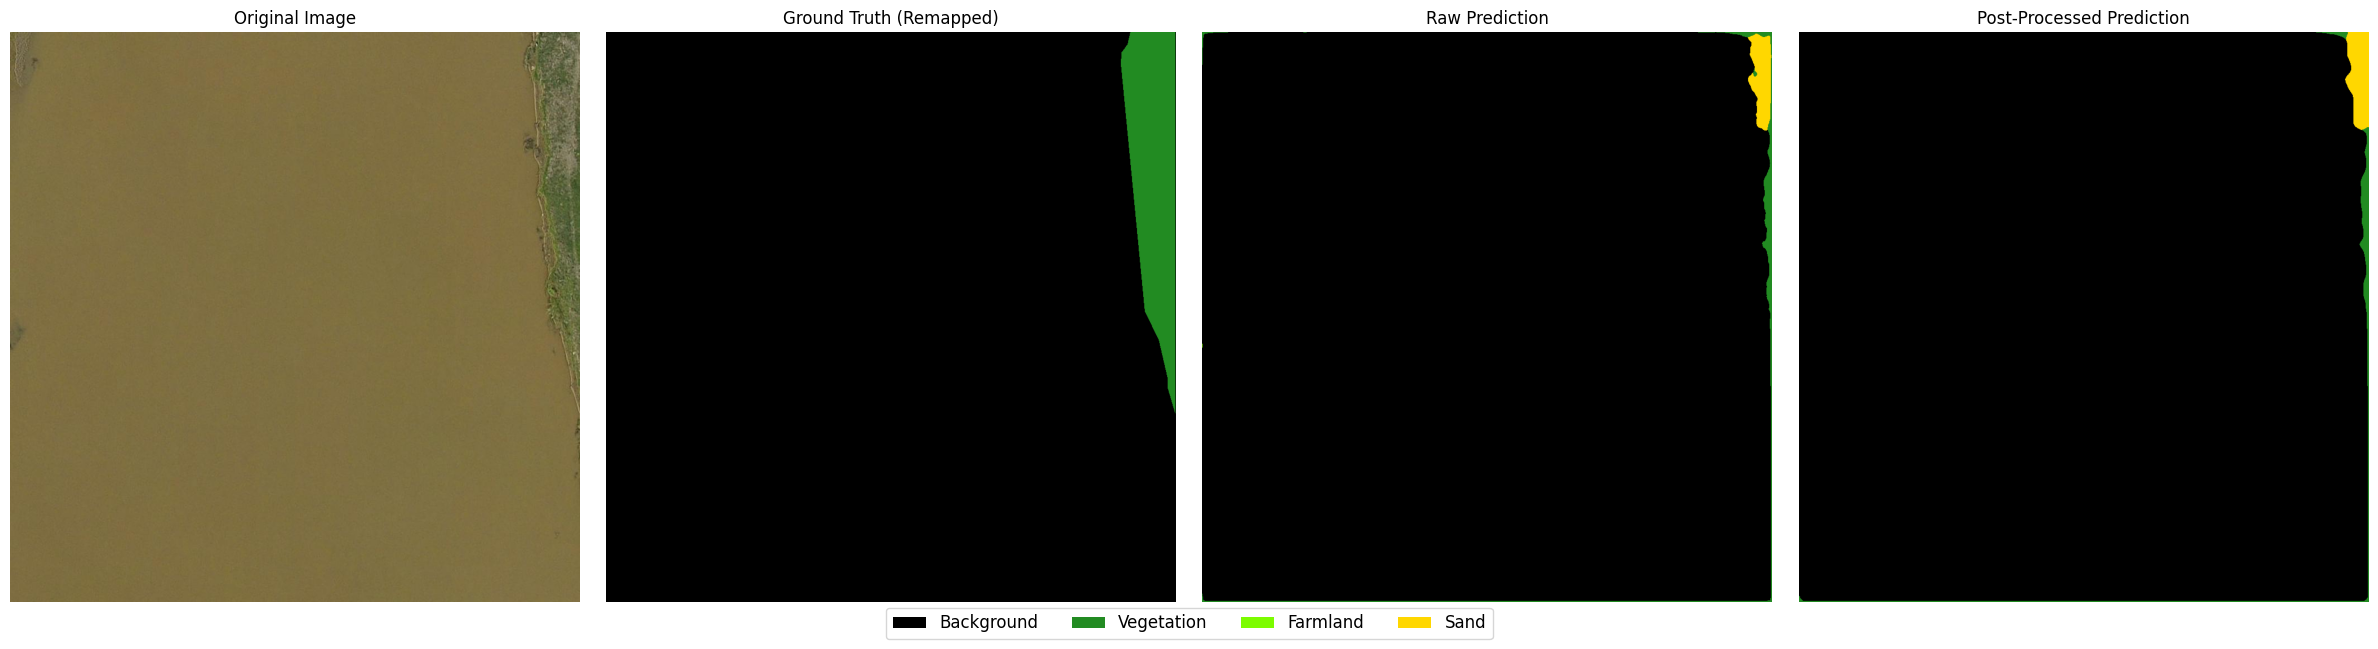

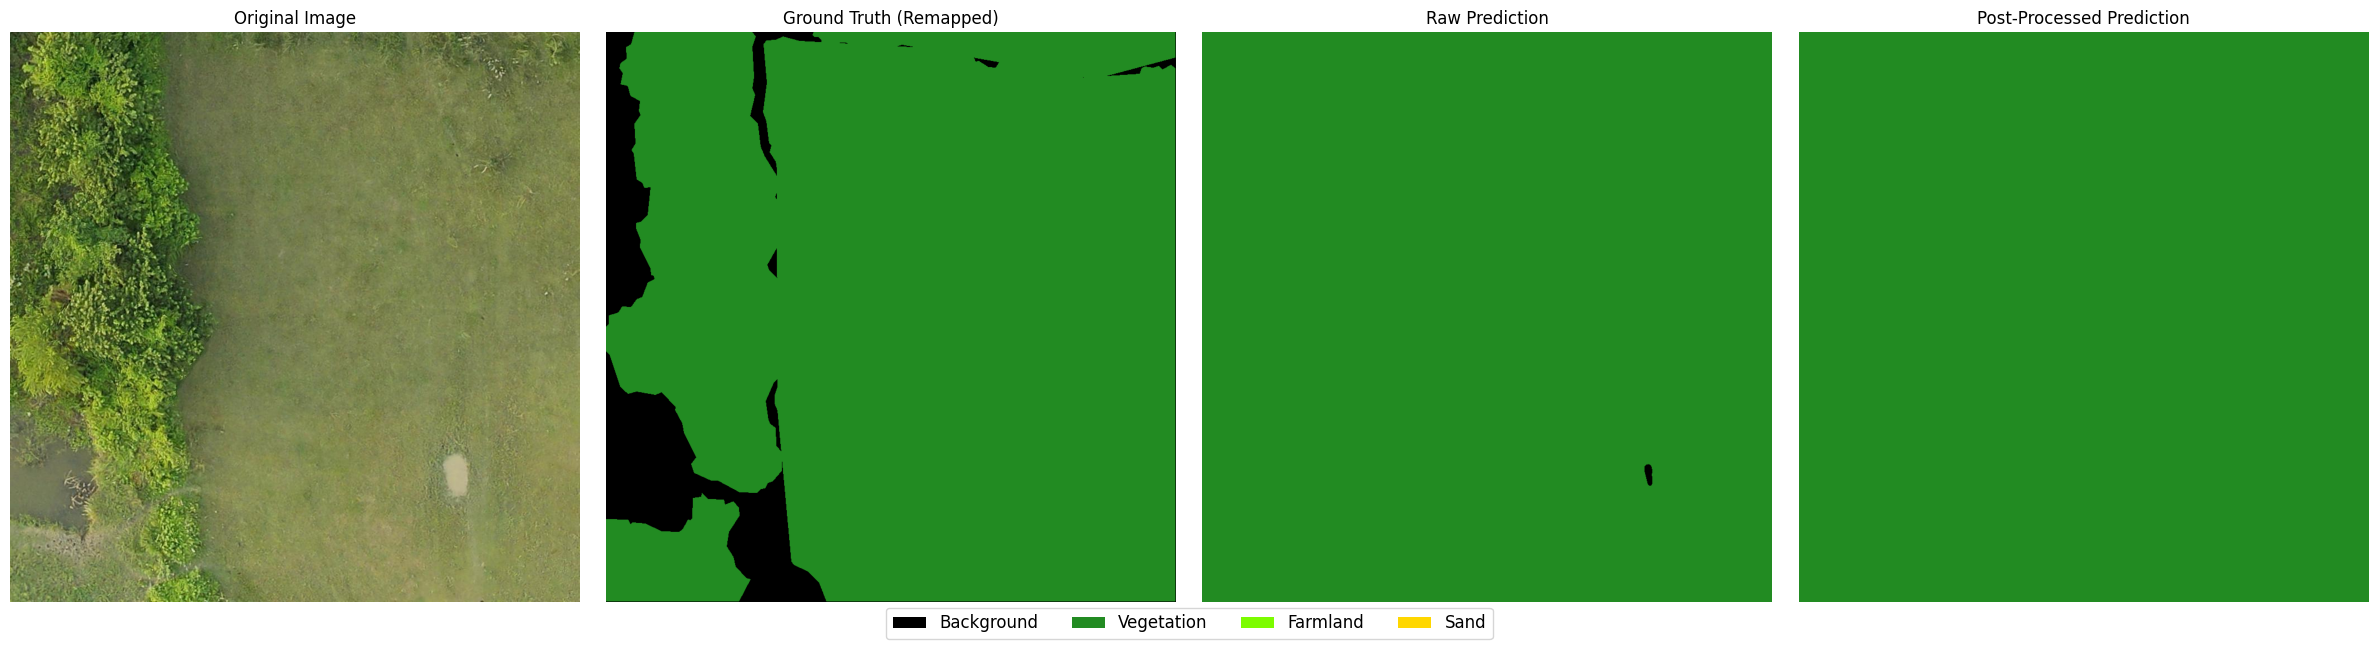

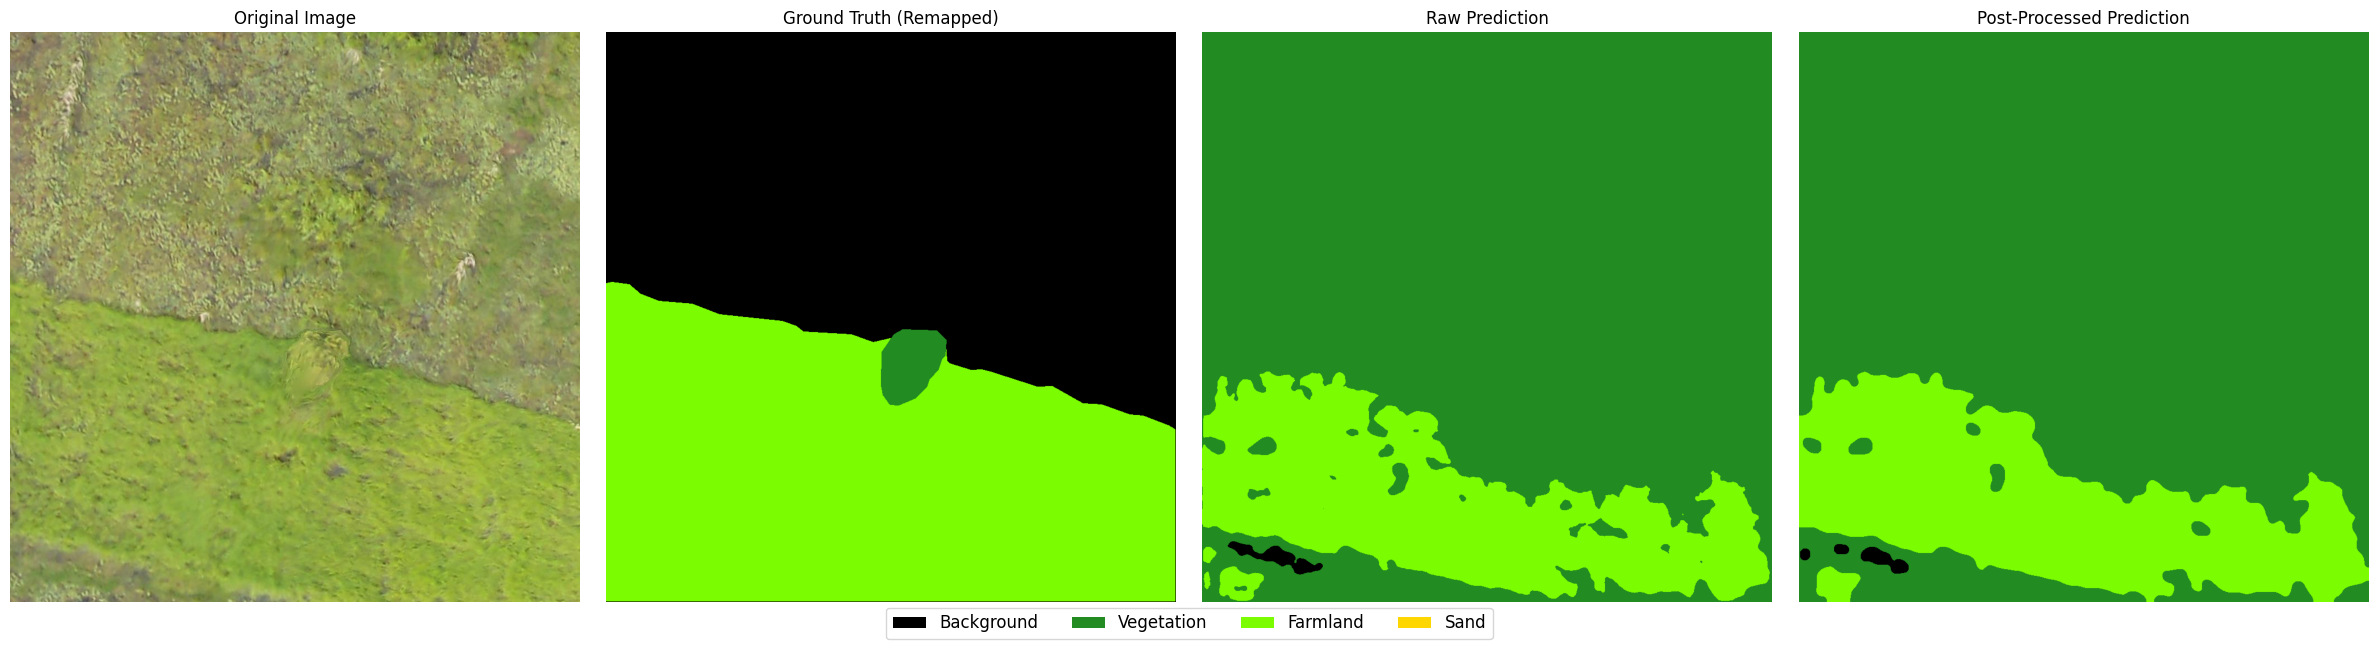

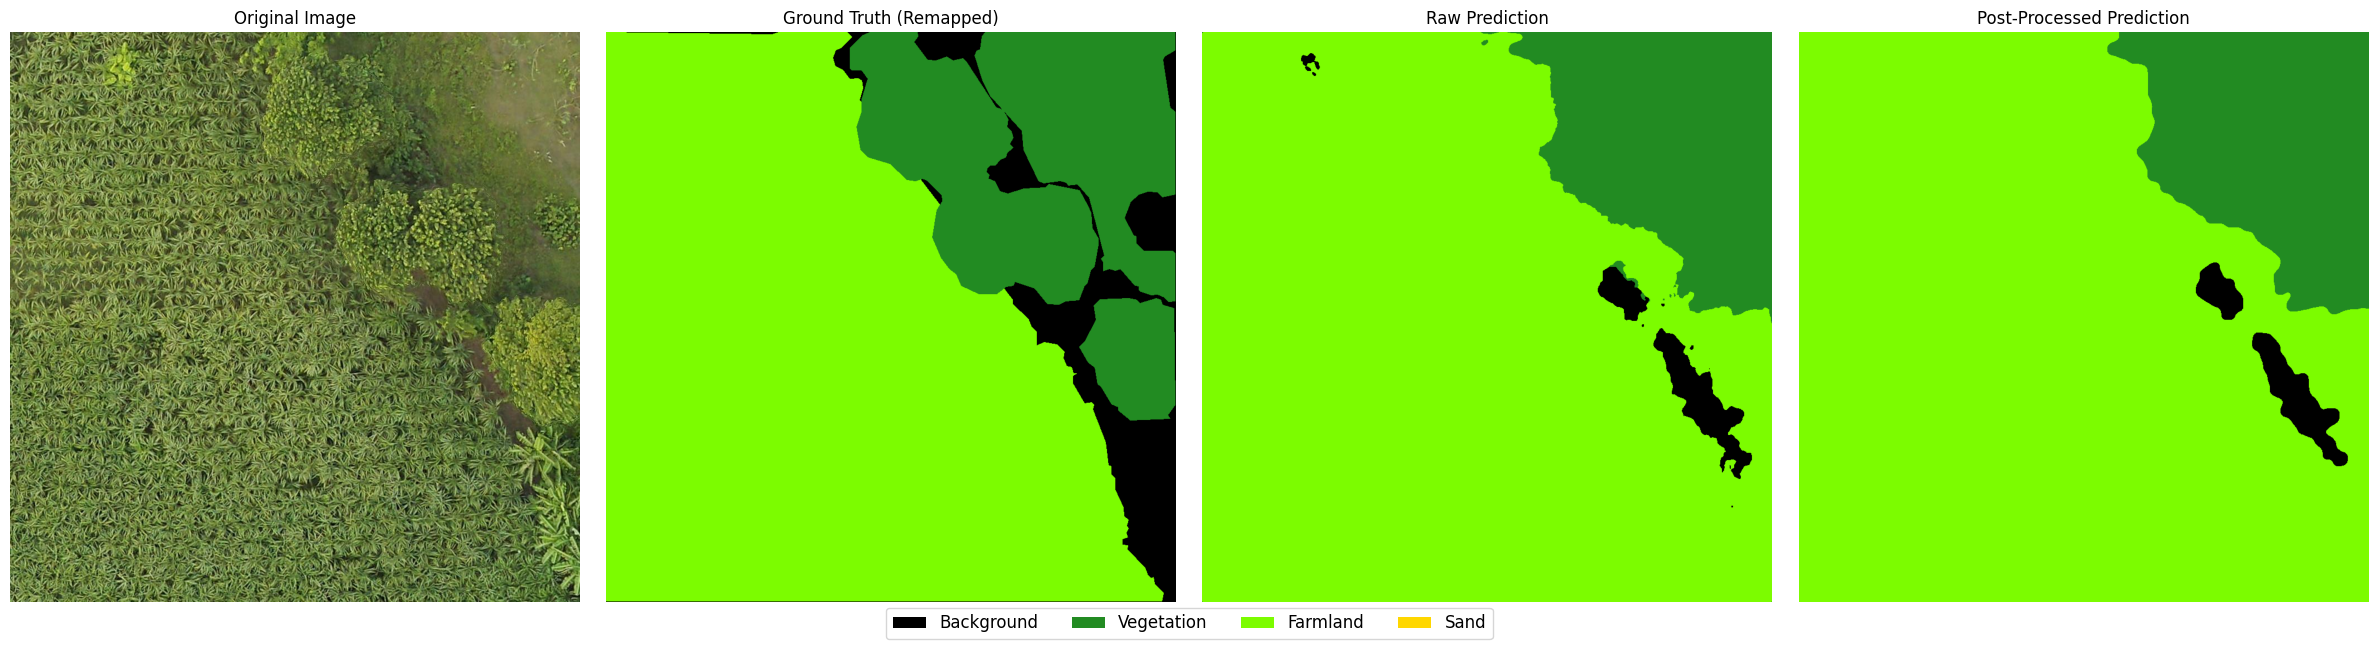

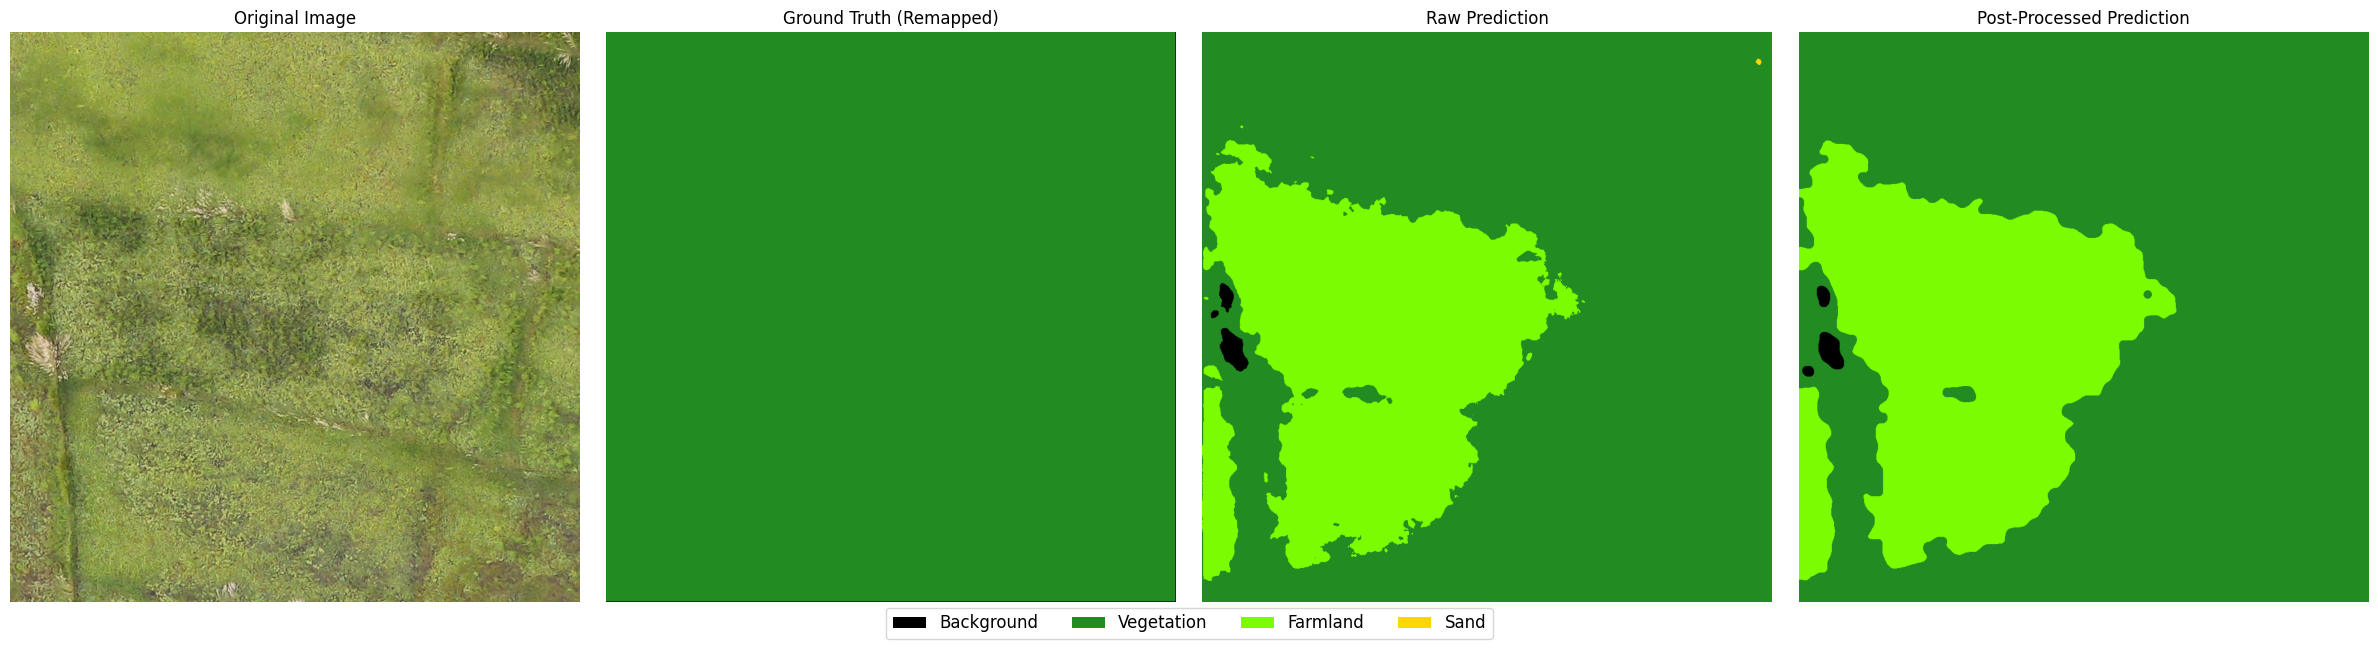

In [25]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib.patches import Patch
import cv2

# ==========================================
# 1. CONFIGURATION
# ==========================================
CONFIG = {
    "TEST_IMG_DIR": "/kaggle/working/train/images",
    "TEST_MASK_DIR": "/kaggle/working/train/masks",
    "MODEL_PATH": "/kaggle/working/vgg16_unet_best_4classes.pth", # Ensure this matches your saved model name
    "IMG_SIZE": 512,
    "NUM_CLASSES": 4,   # 0:Back, 1:Veg, 2:Farm, 3:Sand
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "NUM_SAMPLES": 5    
}

# Colors for 4 Classes
CLASS_COLORS = {
    0: [0, 0, 0],       # Background (Black)
    1: [34, 139, 34],   # Vegetation (Forest Green) - Combines Barren/Bush/Tree
    2: [124, 252, 0],   # Farmland (Lawn Green)
    3: [255, 215, 0],   # Sand (Gold)
}

ID2LABEL = {
    0: "Background",
    1: "Vegetation",
    2: "Farmland",
    3: "Sand"
}

# ==========================================
# 2. MODEL DEFINITION (Must match training)
# ==========================================
class VGG16UNet(nn.Module):
    def __init__(self, num_classes, pretrained=False):
        super(VGG16UNet, self).__init__()
        vgg16 = models.vgg16_bn(weights=None)
        features = list(vgg16.features.children())
        self.enc1 = nn.Sequential(*features[:6])    
        self.enc2 = nn.Sequential(*features[6:13])  
        self.enc3 = nn.Sequential(*features[13:23]) 
        self.enc4 = nn.Sequential(*features[23:33]) 
        self.enc5 = nn.Sequential(*features[33:43]) 
        self.pool = nn.MaxPool2d(2, 2)
        self.up1 = self.conv_block(512 + 512, 512)
        self.up2 = self.conv_block(512 + 256, 256)
        self.up3 = self.conv_block(256 + 128, 128)
        self.up4 = self.conv_block(128 + 64, 64)
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool(e1)
        e2 = self.enc2(p1)
        p2 = self.pool(e2)
        e3 = self.enc3(p2)
        p3 = self.pool(e3)
        e4 = self.enc4(p3)
        p4 = self.pool(e4)
        e5 = self.enc5(p4)
        d1 = F.interpolate(e5, scale_factor=2, mode='bilinear', align_corners=True)
        if d1.size()[2:] != e4.size()[2:]: d1 = F.interpolate(d1, size=e4.shape[2:], mode='bilinear')
        d1 = torch.cat([d1, e4], dim=1)
        d1 = self.up1(d1)
        d2 = F.interpolate(d1, scale_factor=2, mode='bilinear', align_corners=True)
        if d2.size()[2:] != e3.size()[2:]: d2 = F.interpolate(d2, size=e3.shape[2:], mode='bilinear')
        d2 = torch.cat([d2, e3], dim=1)
        d2 = self.up2(d2)
        d3 = F.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=True)
        if d3.size()[2:] != e2.size()[2:]: d3 = F.interpolate(d3, size=e2.shape[2:], mode='bilinear')
        d3 = torch.cat([d3, e2], dim=1)
        d3 = self.up3(d3)
        d4 = F.interpolate(d3, scale_factor=2, mode='bilinear', align_corners=True)
        if d4.size()[2:] != e1.size()[2:]: d4 = F.interpolate(d4, size=e1.shape[2:], mode='bilinear')
        d4 = torch.cat([d4, e1], dim=1)
        d4 = self.up4(d4)
        return self.final_conv(d4)

# ==========================================
# 3. HELPER FUNCTIONS
# ==========================================

def remap_gt_mask(mask):
    """
    Remaps raw GT values to the 4 classes used in training.
    Raw: 0(Bg), 1(Barren), 2(Bush), 3(Farm), 4(Sand), 5(Tree), 6(Edge)
    New: 0(Bg), 1(Veg), 2(Farm), 3(Sand)
    """
    new_mask = np.zeros_like(mask)
    
    # 1. Vegetation = Barren(1) + Bush(2) + Tree(5)
    new_mask[(mask == 1) | (mask == 2) | (mask == 5)] = 1
    
    # 2. Farmland = 3 -> 2
    new_mask[mask == 3] = 2
    
    # 3. Sand = 4 -> 3
    new_mask[mask == 4] = 3
    
    # Background(0) and Edgecase(6) stay 0 (Background)
    return new_mask

def clean_segmentation_mask(mask, min_area=500):
    """
    Post-processing to remove small noise blobs and smooth edges.
    """
    mask = mask.astype(np.uint8)
    cleaned = mask.copy()
    
    # 1. Remove small objects for each class
    for class_id in [1, 2, 3]: # Skip background 0
        binary = (mask == class_id).astype(np.uint8)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if cv2.contourArea(cnt) < min_area:
                cv2.drawContours(cleaned, [cnt], -1, 0, -1) # Fill with background
    
    # 2. Fill holes (Morphological Closing)
    kernel = np.ones((15, 15), np.uint8)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)
    
    # 3. Smooth edges (Median Blur)
    cleaned = cv2.medianBlur(cleaned, 11)
    
    return cleaned

def colorize_mask(mask_2d):
    h, w = mask_2d.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_id, color in CLASS_COLORS.items():
        color_mask[mask_2d == cls_id] = color
    return color_mask

def get_prediction(model, image_np, device):
    transform = A.Compose([
        A.Resize(height=CONFIG['IMG_SIZE'], width=CONFIG['IMG_SIZE']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    
    aug = transform(image=image_np)
    img_tensor = aug["image"].unsqueeze(0).to(device)
    
    with torch.no_grad():
        logits = model(img_tensor)
        logits = F.interpolate(logits, size=image_np.shape[:2], mode='bilinear', align_corners=False)
        pred_mask = torch.argmax(logits, dim=1).squeeze().cpu().numpy()
        
    return pred_mask

# ==========================================
# 4. MAIN INFERENCE
# ==========================================
def main():
    print("Loading Model...")
    model = VGG16UNet(num_classes=CONFIG['NUM_CLASSES'])
    
    if os.path.exists(CONFIG['MODEL_PATH']):
        model.load_state_dict(torch.load(CONFIG['MODEL_PATH'], map_location=CONFIG['DEVICE']))
        print("Model loaded.")
    else:
        print(f"Error: Model not found at {CONFIG['MODEL_PATH']}")
        return

    model.to(CONFIG['DEVICE'])
    model.eval()

    if not os.path.exists(CONFIG['TEST_IMG_DIR']):
        print(f"Directory not found: {CONFIG['TEST_IMG_DIR']}")
        return

    all_files = os.listdir(CONFIG['TEST_IMG_DIR'])
    images = sorted([f for f in all_files if f.endswith('.jpg')])

    if not images:
        print("No images found.")
        return

    # Random Selection
    num_samples = min(CONFIG['NUM_SAMPLES'], len(images))
    selected_images = random.sample(images, num_samples)
    print(f"Visualizing {num_samples} random images...")

    for img_file in selected_images: 
        img_path = os.path.join(CONFIG['TEST_IMG_DIR'], img_file)
        mask_file = img_file.replace(".jpg", "_mask.png")
        mask_path = os.path.join(CONFIG['TEST_MASK_DIR'], mask_file)
        
        # 1. Load Image
        image_np = np.array(Image.open(img_path).convert("RGB"))
        
        # 2. Load and Remap GT
        if os.path.exists(mask_path):
            raw_mask = np.array(Image.open(mask_path).convert("L"))
            gt_mask = remap_gt_mask(raw_mask)
            gt_color = colorize_mask(gt_mask)
        else:
            gt_color = np.zeros_like(image_np)

        # 3. Predict
        raw_pred = get_prediction(model, image_np, CONFIG['DEVICE'])
        
        # 4. Post-Process
        clean_pred = clean_segmentation_mask(raw_pred, min_area=600)
        
        # 5. Colorize
        raw_color = colorize_mask(raw_pred)
        clean_color = colorize_mask(clean_pred)

        # 6. Visualize
        fig, axes = plt.subplots(1, 4, figsize=(24, 6))
        
        axes[0].imshow(image_np)
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        axes[1].imshow(gt_color)
        axes[1].set_title("Ground Truth (Remapped)")
        axes[1].axis('off')
        
        axes[2].imshow(raw_color)
        axes[2].set_title("Raw Prediction")
        axes[2].axis('off')
        
        axes[3].imshow(clean_color)
        axes[3].set_title("Post-Processed Prediction")
        axes[3].axis('off')
        
        # Legend
        legend_elements = [Patch(facecolor=np.array(c)/255, label=name) 
                           for i, (name, c) in zip(ID2LABEL.keys(), zip(ID2LABEL.values(), CLASS_COLORS.values()))]
        fig.legend(handles=legend_elements, loc='lower center', ncol=4, fontsize=12, bbox_to_anchor=(0.5, -0.05))
        
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    main()

In [22]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# ==========================================
# 1. CONFIGURATION
# ==========================================
CONFIG = {
    "TEST_IMG_DIR": "/kaggle/working/test/images", 
    "TEST_MASK_DIR": "/kaggle/working/test/masks",
    
    "MODEL_PATH": "vgg16_unet_best_4classes.pth", # Matches your latest training
    "IMG_SIZE": 512,
    "NUM_CLASSES": 4,  # 0:Back, 1:Veg, 2:Farm, 3:Sand
    "IGNORE_INDEX": 255,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu"
}

ID2LABEL = {
    0: "Background",
    1: "Vegetation", # Combines Barren, Bush, Tree
    2: "Farmland",
    3: "Sand"
}

# ==========================================
# 2. MODEL DEFINITION
# ==========================================
class VGG16UNet(nn.Module):
    def __init__(self, num_classes, pretrained=False):
        super(VGG16UNet, self).__init__()
        vgg16 = models.vgg16_bn(weights=None)
        features = list(vgg16.features.children())

        self.enc1 = nn.Sequential(*features[:6])    
        self.enc2 = nn.Sequential(*features[6:13])  
        self.enc3 = nn.Sequential(*features[13:23]) 
        self.enc4 = nn.Sequential(*features[23:33]) 
        self.enc5 = nn.Sequential(*features[33:43]) 

        self.pool = nn.MaxPool2d(2, 2)

        self.up1 = self.conv_block(512 + 512, 512)
        self.up2 = self.conv_block(512 + 256, 256)
        self.up3 = self.conv_block(256 + 128, 128)
        self.up4 = self.conv_block(128 + 64, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool(e1)
        e2 = self.enc2(p1)
        p2 = self.pool(e2)
        e3 = self.enc3(p2)
        p3 = self.pool(e3)
        e4 = self.enc4(p3)
        p4 = self.pool(e4)
        e5 = self.enc5(p4)

        d1 = F.interpolate(e5, scale_factor=2, mode='bilinear', align_corners=True)
        if d1.size()[2:] != e4.size()[2:]:
            d1 = F.interpolate(d1, size=e4.shape[2:], mode='bilinear', align_corners=True)
        d1 = torch.cat([d1, e4], dim=1)
        d1 = self.up1(d1)

        d2 = F.interpolate(d1, scale_factor=2, mode='bilinear', align_corners=True)
        if d2.size()[2:] != e3.size()[2:]:
            d2 = F.interpolate(d2, size=e3.shape[2:], mode='bilinear', align_corners=True)
        d2 = torch.cat([d2, e3], dim=1)
        d2 = self.up2(d2)

        d3 = F.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=True)
        if d3.size()[2:] != e2.size()[2:]:
            d3 = F.interpolate(d3, size=e2.shape[2:], mode='bilinear', align_corners=True)
        d3 = torch.cat([d3, e2], dim=1)
        d3 = self.up3(d3)

        d4 = F.interpolate(d3, scale_factor=2, mode='bilinear', align_corners=True)
        if d4.size()[2:] != e1.size()[2:]:
            d4 = F.interpolate(d4, size=e1.shape[2:], mode='bilinear', align_corners=True)
        d4 = torch.cat([d4, e1], dim=1)
        d4 = self.up4(d4)

        return self.final_conv(d4)

# ==========================================
# 3. METRICS CALCULATOR CLASS
# ==========================================
class SegmentationMetrics:
    def __init__(self, num_classes, ignore_index=255):
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.confusion_matrix = np.zeros((num_classes, num_classes))

    def update(self, preds, labels):
        preds_flat = preds.flatten()
        labels_flat = labels.flatten()

        # Filter out Ignore Indices
        mask = (labels_flat != self.ignore_index)
        
        preds_flat = preds_flat[mask]
        labels_flat = labels_flat[mask]

        count = np.bincount(
            self.num_classes * labels_flat.astype(int) + preds_flat.astype(int),
            minlength=self.num_classes ** 2
        )
        
        self.confusion_matrix += count.reshape(self.num_classes, self.num_classes)

    def compute_metrics(self):
        tp = np.diag(self.confusion_matrix)
        fp = self.confusion_matrix.sum(axis=0) - tp
        fn = self.confusion_matrix.sum(axis=1) - tp

        eps = 1e-10

        iou = tp / (tp + fp + fn + eps)
        precision = tp / (tp + fp + eps)
        recall = tp / (tp + fn + eps)
        dice = (2 * tp) / (2 * tp + fp + fn + eps)

        return {
            "IoU": iou,
            "Precision": precision,
            "Recall": recall,
            "Dice/F1": dice,
            "Confusion_Matrix": self.confusion_matrix
        }

# ==========================================
# 4. MAIN EXECUTION
# ==========================================
def main():
    print(f"Initializing Evaluation on {CONFIG['DEVICE']}...")
    print(f"Classes: {CONFIG['NUM_CLASSES']} (Background, Veg, Farm, Sand)")
    
    # 1. Load Model
    model = VGG16UNet(num_classes=CONFIG['NUM_CLASSES'])
    if os.path.exists(CONFIG['MODEL_PATH']):
        model.load_state_dict(torch.load(CONFIG['MODEL_PATH'], map_location=CONFIG['DEVICE']))
        print("Model loaded successfully.")
    else:
        print(f"Error: Model not found at {CONFIG['MODEL_PATH']}")
        return
    model.to(CONFIG['DEVICE'])
    model.eval()

    # 2. Setup Metrics
    metrics = SegmentationMetrics(num_classes=CONFIG['NUM_CLASSES'], ignore_index=CONFIG['IGNORE_INDEX'])
    
    # 3. Preprocessing
    transform = A.Compose([
        A.Resize(height=CONFIG['IMG_SIZE'], width=CONFIG['IMG_SIZE']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    # 4. List Images
    if not os.path.exists(CONFIG['TEST_IMG_DIR']):
        print(f"Directory not found: {CONFIG['TEST_IMG_DIR']}")
        return

    all_files = os.listdir(CONFIG['TEST_IMG_DIR'])
    images = sorted([f for f in all_files if f.endswith('.jpg')])
    
    if len(images) == 0:
        print("No images found.")
        return

    print(f"Evaluating on {len(images)} images...")

    # 5. Evaluation Loop
    for img_file in tqdm(images):
        img_path = os.path.join(CONFIG['TEST_IMG_DIR'], img_file)
        
        mask_file = img_file.replace(".jpg", "_mask.png")
        mask_path = os.path.join(CONFIG['TEST_MASK_DIR'], mask_file)
        
        if not os.path.exists(mask_path): continue

        # Load Image
        image = np.array(Image.open(img_path).convert("RGB"))
        
        # Load Mask & Remap
        raw_mask = np.array(Image.open(mask_path).convert("L"))
        
        # ============================================================
        # 🚨 REMAPPING LOGIC (4 Classes) 🚨
        # ============================================================
        # Start with 0 (Background)
        gt_mask = np.zeros_like(raw_mask) 

        # 1. Vegetation (New Class 1) = Barren(1) + Bush(2) + Tree(5)
        gt_mask[(raw_mask == 1) | (raw_mask == 2) | (raw_mask == 5)] = 1
        
        # 2. Farmland (New Class 2) = Old Farmland(3)
        gt_mask[raw_mask == 3] = 2
        
        # 3. Sand (New Class 3) = Old Sand(4)
        gt_mask[raw_mask == 4] = 3
        
        # 4. Ignore: Edgecase(6) and artifacts (>6)
        gt_mask[raw_mask == 6] = CONFIG["IGNORE_INDEX"]
        gt_mask[raw_mask > 6] = CONFIG["IGNORE_INDEX"]
        # ============================================================

        # Preprocess
        aug = transform(image=image)
        img_tensor = aug["image"].unsqueeze(0).to(CONFIG['DEVICE'])

        # Inference
        with torch.no_grad():
            logits = model(img_tensor)
            # Resize logits to match Ground Truth size
            logits = F.interpolate(logits, size=gt_mask.shape, mode='bilinear', align_corners=False)
            pred_mask = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

        # Update Metrics
        metrics.update(pred_mask, gt_mask)

    # 6. Calculate Final Scores
    scores = metrics.compute_metrics()
    
    # 7. Format Results into DataFrame
    results = []
    for i in range(CONFIG['NUM_CLASSES']):
        results.append({
            "Class ID": i,
            "Class Name": ID2LABEL[i],
            "IoU": scores["IoU"][i],
            "Dice (F1)": scores["Dice/F1"][i],
            "Precision": scores["Precision"][i],
            "Recall": scores["Recall"][i]
        })
    
    df = pd.DataFrame(results)
    
    # Calculate Mean IoU
    mIoU = np.nanmean(scores["IoU"])
    mDice = np.nanmean(scores["Dice/F1"])
    
    print("\n" + "="*60)
    print("FINAL EVALUATION REPORT (4 CLASSES)")
    print("="*60)
    print(df.round(4).to_string(index=False))
    print("-" * 60)
    print(f"Mean IoU (mIoU):      {mIoU:.4f}")
    print(f"Mean Dice (mDice):    {mDice:.4f}")
    print("="*60)

    # Optional: Save to CSV
    df.to_csv("evaluation_metrics_final_4classes.csv", index=False)
    print("Metrics saved to 'evaluation_metrics_final_4classes.csv'")

if __name__ == "__main__":
    main()

Initializing Evaluation on cuda...
Classes: 4 (Background, Veg, Farm, Sand)
Model loaded successfully.
Evaluating on 25 images...


100%|██████████| 25/25 [00:01<00:00, 17.93it/s]


FINAL EVALUATION REPORT (4 CLASSES)
 Class ID Class Name    IoU  Dice (F1)  Precision  Recall
        0 Background 0.3653     0.5351     0.5190  0.5523
        1 Vegetation 0.7421     0.8520     0.8935  0.8141
        2   Farmland 0.8278     0.9058     0.8814  0.9315
        3       Sand 0.6885     0.8156     0.8213  0.8099
------------------------------------------------------------
Mean IoU (mIoU):      0.6559
Mean Dice (mDice):    0.7771
Metrics saved to 'evaluation_metrics_final_4classes.csv'
